In [ ]:
import pandas as pd
import numpy as np
#should i normalize?
#featureselection
#length and position of cracks

df = pd.read_csv('/content/Alshim_Fan_combined_dataset.csv')

# Find rows where any value is NaN
rows_with_nan = df[df.isna().any(axis=1)]

# Print the rows
rows_with_nan
df=df.dropna( )
#df=df.drop(columns=['filepath'])
rows_with_nan = df[df.isna().any(axis=1)]

# Print the rows
rows_with_nan

,Frequency,Real,Imaginary,Magnitude,Crack Status


In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost PyWavelets imblearn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import xgboost as xgb
from scipy.stats import variation, skew, kurtosis, zscore
from scipy.signal import find_peaks, welch, savgol_filter
from sklearn.preprocessing import (LabelEncoder, RobustScaler,
                                 FunctionTransformer, QuantileTransformer)
from sklearn.decomposition import FastICA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report,
                            balanced_accuracy_score, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.base import clone
from imblearn.over_sampling import SMOTE
from sklearn.covariance import EmpiricalCovariance

# --- Outlier Removal Utility ---
def remove_outliers_iqr(X, threshold=1.5):
    """Remove/cap outliers using IQR for each feature (column-wise)"""
    X_clean = np.copy(X)
    for col in range(X.shape[1]):
        q1 = np.percentile(X[:, col], 25)
        q3 = np.percentile(X[:, col], 75)
        iqr = q3 - q1
        lower = q1 - threshold * iqr
        upper = q3 + threshold * iqr
        X_clean[:, col] = np.clip(X[:, col], lower, upper)
    return X_clean

# --- Noise Reduction Utility ---
def apply_savgol_filter(X, window_length=5, polyorder=2):
    """Apply Savitzky-Golay filter to each row (signal)"""
    X_filtered = np.copy(X)
    for i in range(X.shape[0]):
        try:
            wl = min(window_length, X.shape[1]//2*2+1)
            if wl < 3: wl = 3
            X_filtered[i] = savgol_filter(X[i], window_length=wl, polyorder=polyorder)
        except:
            pass
    return X_filtered

# --- Data Augmentation Utility ---
def add_gaussian_noise(X, std=0.01):
    """Add Gaussian noise to data"""
    return X + np.random.normal(0, std, X.shape)

def enhanced_feature_extractor(X, use_filter=True, augment_noise=False, remove_outliers=True):
    """
    Enhanced feature extraction without temperature considerations
    Parameters:
        X: Input data matrix
        use_filter: Whether to apply Savitzky-Golay filter
        augment_noise: Whether to add Gaussian noise
        remove_outliers: Whether to remove outliers
    Returns:
        Extracted features array
    """
    # Outlier removal (before smoothing)
    if remove_outliers:
        X = remove_outliers_iqr(X)

    # Optionally apply Savitzky-Golay filter
    if use_filter:
        X = apply_savgol_filter(X)

    if augment_noise:
        X = add_gaussian_noise(X)

    # Spectral features with error handling
    with np.errstate(all='ignore'):
        psd = np.abs(np.fft.fft(np.nan_to_num(X)))**2
        freqs = np.fft.fftfreq(X.shape[1])

    # Peak-based features
    band_features = []
    for spectrum in psd:
        spectrum = np.nan_to_num(spectrum)
        try:
            peaks, _ = find_peaks(spectrum, distance=20, prominence=np.nanmedian(spectrum))
            n_peaks = min(3, len(peaks))
            ratios = peaks[1:n_peaks+1]/peaks[:n_peaks] if len(peaks) > 1 else np.zeros(3)
            heights = spectrum[peaks[1:n_peaks+1]]/spectrum[peaks[:n_peaks]] if len(peaks) > 1 else np.zeros(3)
        except:
            ratios = heights = np.zeros(3)

        band_features.append(np.concatenate([
            np.nan_to_num(ratios),
            np.nan_to_num(heights),
            [len(peaks) if 'peaks' in locals() else 0]
        ]))

    # Time-domain statistics + percentiles
    percentiles = [10, 25, 75, 90]
    stats_features = np.column_stack([
        variation(np.nan_to_num(X), axis=1, nan_policy='omit'),
        skew(np.nan_to_num(X), axis=1, nan_policy='omit'),
        kurtosis(np.nan_to_num(X), axis=1, nan_policy='omit'),
        np.nanmedian(X, axis=1),
        np.nanmax(X, axis=1) - np.nanmin(X, axis=1),
        *[np.percentile(X, p, axis=1) for p in percentiles]
    ])

    # Frequency features
    freq_features = np.zeros((X.shape[0], 3))
    for i, x in enumerate(np.nan_to_num(X)):
        try:
            f, Pxx = welch(x, nperseg=min(64, len(x)//2))
            freq_features[i] = [
                f[np.argmax(Pxx)],
                np.sum(Pxx[f < 0.5*np.max(f)]),
                np.sum(Pxx[f >= 0.5*np.max(f)])
            ]
        except:
            pass

    # Wavelet features
    def safe_wavelet(x):
        try:
            cA, cD = pywt.dwt(np.nan_to_num(x), 'db4')
            return [np.nanmean(cA), np.nanstd(cA), np.nanmean(cD), np.nanstd(cD)]
        except:
            return [0, 0, 0, 0]

    # Combine all features
    features = np.hstack([
        np.nan_to_num(np.array(band_features)),
        np.nan_to_num(stats_features),
        np.nan_to_num(freq_features),
        np.array([safe_wavelet(x) for x in X])
    ])

    return features

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

def enhanced_evaluate_with_metrics(model, X_train, X_test, y_train, y_test, class_labels):
    # Convert string labels to integers for scikit-learn
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    # Resample with SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    # Train model
    model.fit(X_res, y_res)

    # Predict
    y_pred = model.predict(X_test)

    # Convert numeric class labels back to strings for reporting
    str_class_labels = [str(label) for label in np.unique(np.concatenate([y_test, y_pred]))]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(y_test, y_pred)

    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=str_class_labels, zero_division=0))

    # Confusion Matrix with string labels
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=str_class_labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    return {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Kappa": kappa,
        "Confusion Matrix": cm
    }


# Optimized Preprocessing
def build_preprocessor():
    return make_pipeline(
        FunctionTransformer(enhanced_feature_extractor,
                          kw_args={'use_filter': True, 'augment_noise': False, 'remove_outliers': True}),
        RobustScaler(),
        QuantileTransformer(output_distribution='normal', random_state=42),
        FastICA(n_components=10, whiten='unit-variance',
               random_state=42, tol=0.01)
    )

MODELS = {
    'SVM (RBF)': SVC(C=1.0, kernel='rbf', class_weight='balanced',
                    probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=300,
                                         class_weight='balanced',
                                         max_depth=None,
                                         min_samples_leaf=2,
                                         random_state=42),
    'XGBoost': xgb.XGBClassifier(objective='multi:softprob',
                               n_estimators=300,
                               learning_rate=0.05,
                               max_depth=6,
                               reg_alpha=1,
                               reg_lambda=1,
                               random_state=42)
}

def evaluate_model(model, X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {
        'Accuracy': [], 'Balanced Accuracy': [], 'Macro F1': [],
        **{f'Class {i}_Recall': [] for i in np.unique(y)}
    }
    target_names = [str(label) for label in np.unique(y)]

    for train_idx, val_idx in kf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        # Resampling
        smote = SMOTE(sampling_strategy='not majority', random_state=42)
        X_res, y_res = smote.fit_resample(X_tr, y_tr)

        # Train and evaluate
        clf = clone(model).fit(X_res, y_res)
        y_pred = clf.predict(X_val)
        report = classification_report(y_val, y_pred, target_names=target_names, output_dict=True, zero_division=0)

        # Store metrics
        metrics['Accuracy'].append(accuracy_score(y_val, y_pred))
        metrics['Balanced Accuracy'].append(balanced_accuracy_score(y_val, y_pred))
        metrics['Macro F1'].append(report['macro avg']['f1-score'])

        for cls in report:
            if cls.isdigit():
                metrics[f'Class {cls}_Recall'].append(report[cls]['recall'])

    return {k: np.mean(v) for k, v in metrics.items()}

# ----------------------- #
# 🚀 Master Pipeline
def run_wind_analysis_pipeline(df, target_col="Crack Status"):
    # Initial checks
    print(" Initial Data Inspection")
    print(f"Dataset shape: {df.shape}")
    print(f"Class distribution:\n{df[target_col].value_counts()}")

    # Prepare data
    X = df.drop(columns=[target_col]).values
    y = LabelEncoder().fit_transform(df[target_col].values)

    # Build preprocessing
    preprocessor = build_preprocessor()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)

    # Transform data
    X_train_trans = preprocessor.fit_transform(X_train)
    X_test_trans = preprocessor.transform(X_test)

    # Train and evaluate models
    results = []
    for name, model in MODELS.items():
        print(f"\n Training {name}...")
        class_labels = sorted(df[target_col].unique())
        metrics = enhanced_evaluate_with_metrics(model, X_train_trans, X_test_trans, y_train, y_test, class_labels)
        metrics['Model'] = name
        results.append(metrics)

        # Adjust class weights if XGBoost
        if name == 'XGBoost':
            class_counts = np.bincount(y_train)
            scale_pos_weight = (class_counts[0] / class_counts[1]) if len(class_counts) > 1 else 1
            model.set_params(scale_pos_weight=scale_pos_weight)

        scores = evaluate_model(model, X_train_trans, y_train)
        scores['Model'] = name
        results.append(scores)

    # Train final model
    final_model = clone(MODELS['XGBoost'])
    X_res, y_res = SMOTE(random_state=42).fit_resample(X_train_trans, y_train)
    final_model.fit(X_res, y_res)

    # Feature importance
    if hasattr(final_model, 'feature_importances_'):
        plt.figure(figsize=(12, 6))
        pd.Series(final_model.feature_importances_).plot(kind='bar')
        plt.title('Feature Importance')
        plt.show()

    return pd.DataFrame(results), {
        "SVM (RBF)": clone(MODELS["SVM (RBF)"]).fit(X_res, y_res),
        "Random Forest": clone(MODELS["Random Forest"]).fit(X_res, y_res),
        "XGBoost": final_model
    }, final_model, preprocessor

 Initial Data Inspection
Dataset shape: (3960, 5)
Class distribution:
Crack Status
0    990
1    990
2    990
3    990
Name: count, dtype: int64

 Training SVM (RBF)...

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.93       198
           1       0.95      0.87      0.91       198
           2       0.91      0.97      0.94       198
           3       0.87      1.00      0.93       198

    accuracy                           0.93       792
   macro avg       0.93      0.93      0.93       792
weighted avg       0.93      0.93      0.93       792



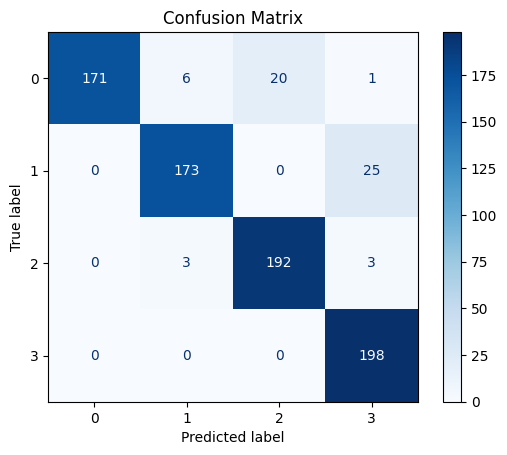


 Training Random Forest...

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       198
           1       0.97      0.99      0.98       198
           2       0.95      0.98      0.96       198
           3       0.98      0.99      0.98       198

    accuracy                           0.97       792
   macro avg       0.97      0.97      0.97       792
weighted avg       0.97      0.97      0.97       792



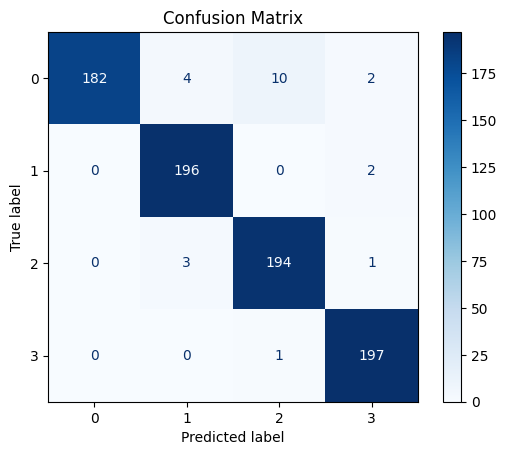


 Training XGBoost...

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       198
           1       0.96      0.98      0.97       198
           2       0.97      0.97      0.97       198
           3       0.98      0.99      0.98       198

    accuracy                           0.97       792
   macro avg       0.97      0.97      0.97       792
weighted avg       0.97      0.97      0.97       792



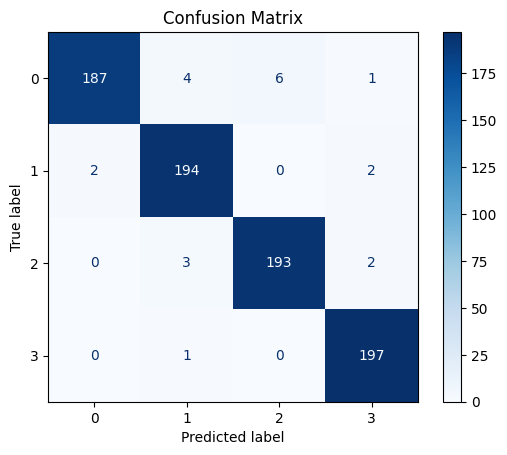

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:04:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:04:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:04:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:04:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:04:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weigh

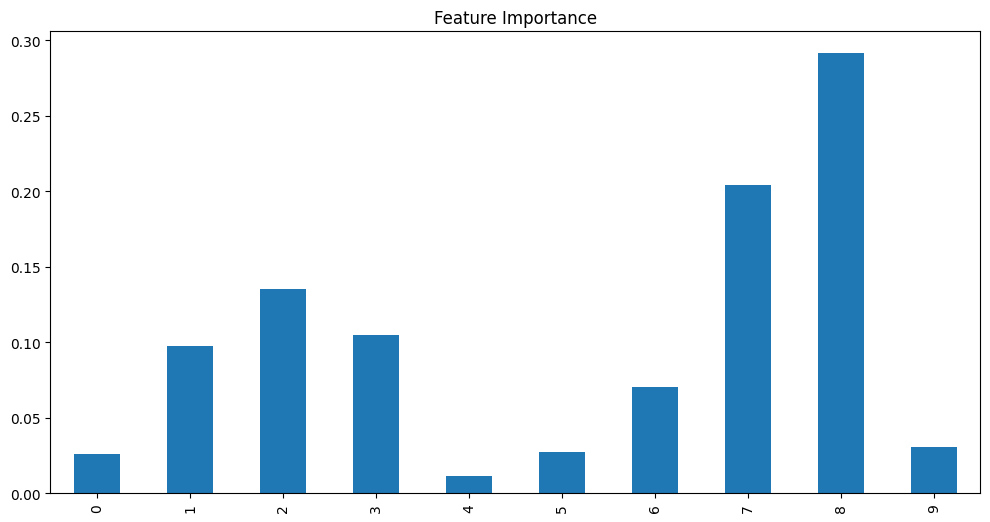


🧾 Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       248
           1       0.97      0.98      0.98       247
           2       0.98      0.98      0.98       248
           3       0.98      1.00      0.99       247

    accuracy                           0.98       990
   macro avg       0.98      0.98      0.98       990
weighted avg       0.98      0.98      0.98       990



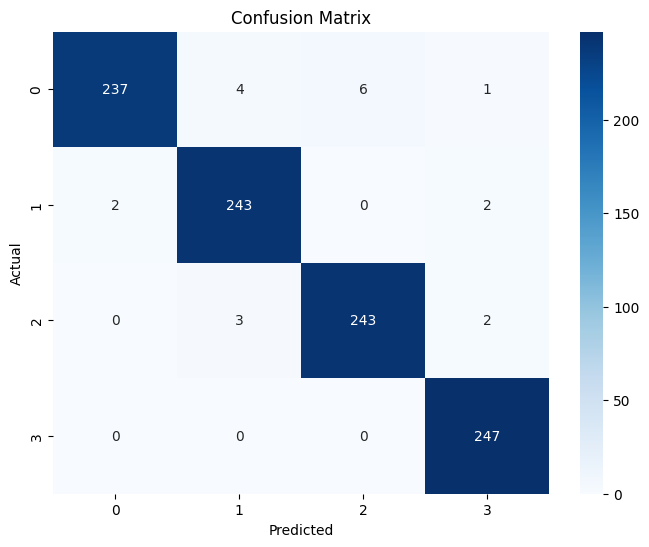

In [ ]:
if __name__ == "__main__":
    # Step 1: Convert labels to integers
    df["Crack Status"] = df["Crack Status"].astype(int)

    # Step 2: Run the pipeline
    results_df, models, final_model, preprocessor = run_wind_analysis_pipeline(
        df,
        target_col="Crack Status"
    )

    # Step 3: Evaluation
    X = df.drop(columns=["Crack Status"]).values
    y = df["Crack Status"].values  # Now integers

    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=42
    )

    # Get class names as strings for reporting
    class_names = [str(label) for label in np.unique(y)]

    # Transform test data
    X_test_trans = preprocessor.transform(X_test)

    # Predict (will return integers)
    y_pred = final_model.predict(X_test_trans)

    # Step 4: Reporting
    print("\n🧾 Classification Report on Test Set:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    # Confusion Matrix with string labels
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt='d',
                xticklabels=class_names,
                yticklabels=class_names,
                cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
def predict_new_data(models, preprocessor, encoder, new_data_path, original_data=None, feature_stats=None):
    import pandas as pd
    import numpy as np
    from collections import Counter
    from sklearn.preprocessing import MinMaxScaler

    # Load and prepare new data
    new_data = pd.read_csv(new_data_path)
    print("\n📊 Data Shape Analysis:")
    print(f"New data shape: {new_data.shape}")

    # Column setup and validation
    if new_data.shape[1] == 3:
        new_data.columns = ['Frequency', 'Real', 'Imaginary']
        new_data['Magnitude'] = np.sqrt(new_data['Real']**2 + new_data['Imaginary']**2)
        print("Added Magnitude column from Real & Imaginary.")
    elif new_data.shape[1] == 4:
        new_data.columns = ['Frequency', 'Real', 'Imaginary', 'Magnitude']

    # Input data validation
    print("\n📊 Input Data Statistics:")
    for col in ['Frequency', 'Real', 'Imaginary', 'Magnitude']:
        stats = new_data[col].describe()
        print(f"{col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.2f}")
        if new_data[col].isna().any():
            print(f"⚠️ Warning: {col} contains {new_data[col].isna().sum()} NaN values")
            new_data[col].fillna(new_data[col].mean(), inplace=True)

    # Compare distributions with original data
    if original_data is not None:
        print("\n🔍 Distribution Analysis:")
        scaler = MinMaxScaler()
        for col in ['Real', 'Imaginary', 'Magnitude']:
            orig_stats = original_data[col].describe()
            new_stats = new_data[col].describe()
            print(f"\n{col} comparison:")
            print(f"Original range: [{orig_stats['min']:.2f}, {orig_stats['max']:.2f}], mean: {orig_stats['mean']:.2f}")
            print(f"New data range: [{new_stats['min']:.2f}, {new_stats['max']:.2f}], mean: {new_stats['mean']:.2f}")

            # Calculate distribution shift
            dist_shift = abs(orig_stats['mean'] - new_stats['mean']) / (orig_stats['std'] + 1e-10)
            print(f"Distribution shift (σ): {dist_shift:.2f}")
            if dist_shift > 2:
                print("⚠️ Warning: Significant distribution shift detected!")
                # Normalize to training data range
                new_data[col] = scaler.fit_transform(new_data[[col]]) * (orig_stats['max'] - orig_stats['min']) + orig_stats['min']
                print(f"Applied range normalization to {col}")

    # Prepare features
    X_clean = new_data[['Frequency', 'Real', 'Imaginary', 'Magnitude']].values
    X_clean = np.nan_to_num(X_clean, nan=0.0, posinf=1.0, neginf=-1.0)

    # Debug feature extraction
    try:
        print("\n🔧 Feature Extraction Debug:")
        X_features = preprocessor.named_steps['functiontransformer'].transform(X_clean)
        print(f"Raw features shape: {X_features.shape}")

        # Check for NaN/Inf values
        nan_count = np.isnan(X_features).sum()
        inf_count = np.isinf(X_features).sum()
        if nan_count > 0 or inf_count > 0:
            print(f"⚠️ Warning: Found {nan_count} NaN and {inf_count} Inf values in features")
            X_features = np.nan_to_num(X_features, nan=0.0, posinf=1.0, neginf=-1.0)

        # Apply processing pipeline
        X_processed = preprocessor.transform(X_clean)
        print(f"Processed features shape: {X_processed.shape}")

        # Clip extreme values
        X_processed = np.clip(X_processed, -3, 3)
        print("\nFeature value ranges after clipping:")
        print(f"Min: {X_processed.min():.2f}, Max: {X_processed.max():.2f}")

    except Exception as e:
        raise ValueError(f"Feature extraction failed: {str(e)}")

    # Feature drift validation
    validation_report = {}
    if feature_stats:
        validation_report = {
            'mean_drift': np.mean(np.abs(
                (np.mean(X_features, axis=0) - feature_stats['means']) / (feature_stats['stds'] + 1e-10)
            )),
            'range_violations': np.sum(
                (X_features < feature_stats['min']) | (X_features > feature_stats['max'])
            ) / X_features.size
        }
        print("\n🔍 Feature Validation:")
        print(f"Mean Z-score drift: {validation_report['mean_drift']:.2f}")
        print(f"% values outside training range: {validation_report['range_violations'] * 100:.1f}%")

    # Model predictions
    raw_predictions = {}
    all_preds = []

    for model_name, model in models.items():
        try:
            preds = model.predict(X_processed)
            probs = model.predict_proba(X_processed) if hasattr(model, 'predict_proba') else None

            raw_predictions[model_name] = {
                'classes': preds,
                'probabilities': probs,
                'confidence': np.max(probs, axis=1) if probs is not None else None
            }
            all_preds.append(preds)

            # Print prediction confidence
            if probs is not None:
                mean_conf = np.mean(raw_predictions[model_name]['confidence'])
                print(f"\n{model_name} mean prediction confidence: {mean_conf:.2f}")

        except Exception as e:
            print(f"⚠️ {model_name} failed: {str(e)}")

    # Majority voting with confidence weighting
    majority_vote = None
    if len(all_preds) >= 2:
        majority_vote = np.apply_along_axis(
            lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=np.array(all_preds)
        )
        print("\n📊 Consensus Predictions:")
        for class_id, count in Counter(majority_vote).items():
            try:
                label = encoder.inverse_transform([class_id])[0]
                print(f"{label} (Class {class_id}): {count} samples")
            except:
                print(f"Class {class_id}: {count} samples")

    return {
        'raw_predictions': raw_predictions,
        'processed_features': X_processed,
        'majority_vote': majority_vote,
        'validation_report': validation_report,
        'feature_debug': {
            'raw_shape': X_features.shape,
            'processed_shape': X_processed.shape,
            'nan_count': nan_count,
            'inf_count': inf_count,
            'value_range': (X_processed.min(), X_processed.max())
        }
    }

In [ ]:
# labels = ['Healthy', 'Quarter', 'Half', 'Full']
# encoder = LabelEncoder()
# encoder.fit(labels)
# print(encoder.classes_)  # Should show ['Full', 'Half', 'Healthy', 'Quarter']
encoder = LabelEncoder().fit(df["Crack Status"])

In [ ]:
test_csv_path = '/content/CF_HC_fan.csv'

# Usage:
predictions = predict_new_data(
    models=models,
    preprocessor=preprocessor,
    encoder=encoder,
    new_data_path=test_csv_path,
    original_data=df  # Pass your training dataframe here
)

# Individual Model Prediction Breakdown
print("\nPer-Model Class Distributions:")
for model_name, result in predictions['raw_predictions'].items():
    print(f"\n{model_name} Prediction Breakdown:")
    classes, counts = np.unique(result['classes'], return_counts=True)
    for cls, count in zip(classes, counts):
        label = encoder.inverse_transform([cls])[0]
        print(f" {label} (Class {cls}): {count} samples")

FileNotFoundError: [Errno 2] No such file or directory: '/content/CF_HC_fan.csv'